In [188]:
# 构建基类
class Node:
    """
    Each node in neural networks will have these attributes and methods
    """
    def __init__(self, inputs=[]):
        """
        if the node is the operator of "ax + b", the inputs will be x node , and the outputs 
        of this is its successors. 
        
        and the value is *ax + b*
        """
        self.inputs = inputs
        self.value = None
        self.outputs = []
        self.gradients = {}
        
        for node in self.inputs:
            node.outputs.append(self)# build a connection relationship
            
    def forward(self):
        """Forward propogation
        
        compute the output value based on input nodes and store the value 
        into *self.value*
        """
        raise NotImplemented
        
    def backward(self):
        """ Back propogation
        
        compute the gradient of each input node and store the value 
        into "self.gredients"
        """
        raise NotImplemented

In [189]:
class Input(Node):
    def __init__(self, name=''):
        Node.__init__(self, inputs=[])
        self.name = name
        
    def forward(self, value=None):
        if value is not None:
            self.value = value
            
    def backward(self):
        self.gradients = {}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost
    
    def __repr__(self):
        return 'Input Node:{}'.format(self.name)

In [190]:
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias
        Node.__init__(self, inputs=[nodes, weights, bias])
        
    def forward(self):
        """compute the wx + b using numpy"""
        self.value = np.dot(self.x_node.value, self.w_node.value) + self.b_node.value
        
    def backward(self):
        for node in self.outputs:
            grad_cost = node.gradients[self]
            
            self.gradients[self.w_node] = np.dot(self.x_node.value.T, grad_cost)
            self.gradients[self.b_node] = np.sum(grad_cost * 1, axis=0, keepdims=False)
            self.gradients[self.x_node] = np.dot(grad_cost, self.w_node.value.T)

In [191]:
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
        self.x_node = node
        
    def _sigmoid(self, x):
        return 1. / (1 + np.exp(-1 * x))
    
    def forward(self):
        self.value = self._sigmoid(self.x_node.value)
        
    def backward(self):
        y = self.value
        
        self.partial = y * (1 - y)
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.x_node] = grad_cost * self.partial

In [192]:
class MSE(Node):
    def __init__(self, y_true, y_hat):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        Node.__init__(self, inputs=[y_true, y_hat])
        
    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1, 1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1, 1)
        
        self.diff = y_true_flatten - y_hat_flatten
        
        self.value = np.mean(self.diff ** 2)
        
    def backward(self):
        n = self.y_hat_node.value.shape[0]
        
        self.gradients[self.y_true_node] = (2 / n) * self.diff
        self.gradients[self.y_hat_node] = (-2 / n) * self.diff

In [193]:
def training_one_batch(topological_sorted_graph):
    # graph 是经过拓扑排序之后的 一个list
    for node in topological_sorted_graph:
        node.forward()
        
    for node in topological_sorted_graph[::-1]:
        node.backward()

In [194]:
def topological_sort(data_with_value):
    feed_dict = data_with_value
    input_nodes = [n for n in feed_dict.keys()]
    
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
            
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        
        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds
            
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

In [195]:
def sgd_update(trainable_nodes, learning_rate=1e-2):
    for t in trainable_nodes:
        t.value += -1 * learning_rate * t.gradients[t]

In [196]:
from sklearn.datasets import load_boston
import numpy as np

In [197]:
data = load_boston()

In [198]:
X_ = data['data']

In [199]:
y_ = data['target']

In [200]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [201]:
y_[0]

24.0

In [202]:
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

In [203]:
X_[0]

array([-0.41978194,  0.28482986, -1.2879095 , -0.27259857, -0.14421743,
        0.41367189, -0.12001342,  0.1402136 , -0.98284286, -0.66660821,
       -1.45900038,  0.44105193, -1.0755623 ])

In [204]:
n_features = X_.shape[1]

In [205]:
n_features

13

In [206]:
n_hidden = 10

In [207]:
W1_, b1_ = np.random.randn(n_features, n_hidden), np.zeros(n_hidden)

In [208]:
W2_, b2_ = np.random.randn(n_hidden, 1), np.zeros(1)

## Build a graph connection 

### 1st. Build Nodes in this graph

In [209]:
X, y = Input(name='X'), Input(name='y')  # tensorflow -> placeholder
W1, b1 = Input(name='W1'), Input(name='b1')
W2, b2 = Input(name='W2'), Input(name='b2')

### 2nd build connection relationship

In [210]:
linear_output = Linear(X, W1, b1)
sigmoid_output = Sigmoid(linear_output)
yhat = Linear(sigmoid_output, W2, b2)
loss = MSE(y, yhat)

In [211]:
input_node_with_value = {  # -> feed_dict 
    X: X_, 
    y: y_, 
    W1: W1_, 
    W2: W2_, 
    b1: b1_, 
    b2: b2_
}

In [212]:
graph = topological_sort(input_node_with_value)

In [213]:
graph

[Input Node:y,
 Input Node:b1,
 Input Node:b2,
 Input Node:X,
 Input Node:W2,
 Input Node:W1,

In [214]:
from sklearn.utils import resample

In [215]:
def run(dictionary):
    return topological_sort(dictionary)

In [216]:
losses = []
epochs = 5000

batch_size = 64

steps_per_epoch = X_.shape[0] // batch_size


for i in range(epochs):
    loss = 0
    
    for batch in range(steps_per_epoch):
        #indices = np.random.choice(range(X_.shape[0]), size=10, replace=True)
        #X_batch = X_[indices]
        #y_batch = y_[indices]
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        
        X.value = X_batch
        y.value = y_batch
        
        input_node_with_value = {  # -> feed_dict 
            X: X_batch, 
            y: y_batch, 
            W1: W1.value, 
            W2: W2.value, 
            b1: b1.value, 
            b2: b2.value,
        }
        
        graph = topological_sort(input_node_with_value)
        
        training_one_batch(graph)
        
        learning_rate = 1e-3
        
        sgd_update(trainable_nodes=[W1, W2, b1, b2], learning_rate=learning_rate)
        
        loss += graph[-1].value
        
    if i % 100 == 0:
        print('Epoch: {}, loss = {:.3f}'.format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Epoch: 1, loss = 668.450
Epoch: 101, loss = 44.847
Epoch: 201, loss = 20.437
Epoch: 301, loss = 22.616
Epoch: 401, loss = 15.613
Epoch: 501, loss = 11.454
Epoch: 601, loss = 15.164
Epoch: 701, loss = 16.672
Epoch: 801, loss = 11.193
Epoch: 901, loss = 11.996
Epoch: 1001, loss = 12.728
Epoch: 1101, loss = 14.035
Epoch: 1201, loss = 15.115
Epoch: 1301, loss = 10.058
Epoch: 1401, loss = 8.856
Epoch: 1501, loss = 10.586
Epoch: 1601, loss = 10.157
Epoch: 1701, loss = 9.834
Epoch: 1801, loss = 9.461
Epoch: 1901, loss = 8.108
Epoch: 2001, loss = 8.884
Epoch: 2101, loss = 8.083
Epoch: 2201, loss = 8.365
Epoch: 2301, loss = 9.077
Epoch: 2401, loss = 8.105
Epoch: 2501, loss = 8.787
Epoch: 2601, loss = 9.120
Epoch: 2701, loss = 8.057
Epoch: 2801, loss = 7.317
Epoch: 2901, loss = 7.237
Epoch: 3001, loss = 6.551
Epoch: 3101, loss = 6.748
Epoch: 3201, loss = 8.296
Epoch: 3301, loss = 7.897
Epoch: 3401, loss = 8.342
Epoch: 3501, loss = 5.706
Epoch: 3601, loss = 9.272
Epoch: 3701, loss = 7.227
Epoch: 

In [218]:
%matplotlib inline

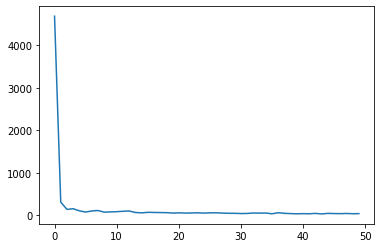

In [219]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [224]:
W1.value

array([[-0.13663421,  0.22374368, -0.33617098, -0.03418939,  1.05173538,
        -1.38007919, -1.19023532, -0.16728608,  0.019904  , -0.51419388],
       [-0.24766903,  0.80978349, -1.06273972,  0.52459828,  1.98224274,
        -0.82018162, -0.41542235,  0.34599292,  0.98012782,  0.51702072],
       [ 0.71540421, -1.59658653, -0.9189312 , -0.40673101,  2.87572519,
         0.30537921,  0.30775515,  2.03854972,  0.58171353, -0.56083485],
       [ 3.42576995, -0.401666  , -0.39993371,  0.27509009, -0.53201043,
        -0.46826939, -0.2046355 , -0.6678955 , -0.43618789,  0.05451637],
       [ 1.12589467, -0.29403547, -1.28242167, -1.54586614,  0.82954922,
         1.54551572, -0.88025035, -3.74961279, -0.27512808, -0.56071938],
       [ 2.21681268, -0.54859361, -1.85471471, -0.57183995,  2.39950762,
         1.2947656 ,  2.26461197,  1.17092426, -1.13953917, -0.15384113],
       [-1.6373109 ,  0.82653768, -0.99279924,  0.52112135, -0.5306854 ,
        -2.03088939,  0.92337756, -0.74094807

In [225]:
W2.value

array([[ 6.49983529],
       [ 6.23461913],
       [ 5.60559568],
       [10.38018383],
       [ 4.65651678],
       [ 4.8145799 ],
       [ 8.46787127],
       [ 5.33829821],
       [-1.71652782],
       [ 3.14143251]])

In [226]:
X_[1]

array([-0.41733926, -0.48772236, -0.59338101, -0.27259857, -0.74026221,
        0.19427445,  0.36716642,  0.55715988, -0.8678825 , -0.98732948,
       -0.30309415,  0.44105193, -0.49243937])

In [227]:
def _sigmoid(x):
    return 1. / (1 + np.exp(-1 * x))

In [228]:
np.dot(_sigmoid(np.dot(X_[1], W1.value) + b1.value), W2.value) + b2.value

array([23.89075963])

In [229]:
y_[1]

21.6